In [1]:
import numpy as np
import pandas as pd

import re
import string
import nltk
from nltk.corpus import stopwords

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 실행하지 않음
print(os.listdir("../input/"))

In [3]:
train = pd.read_csv('train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv('test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [7]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

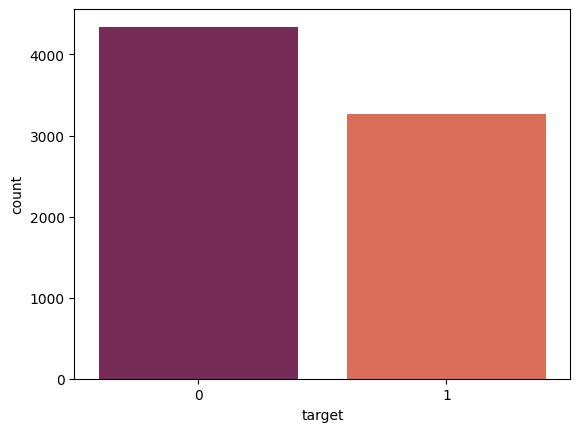

In [11]:
sns.barplot(x=train['target'].value_counts().index,y=train['target'].value_counts(),palette='rocket')

In [12]:
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [13]:
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

<Axes: xlabel='count', ylabel='keyword'>

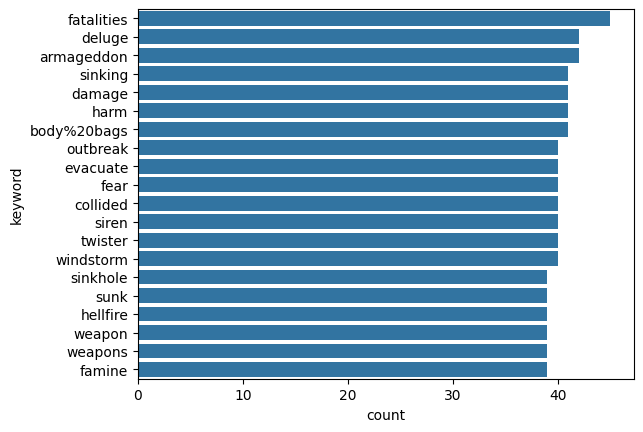

In [14]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

In [15]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='location'>

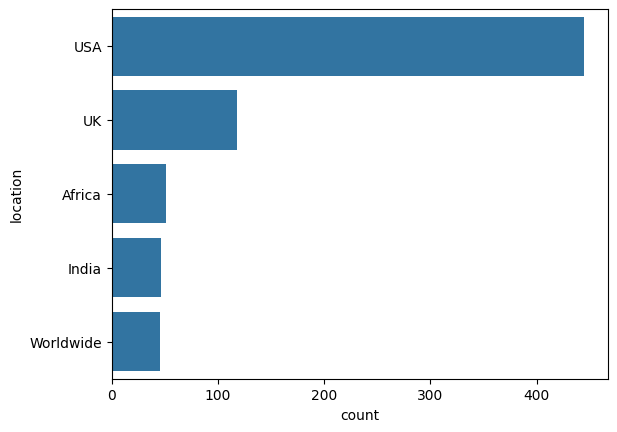

In [16]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

In [17]:
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

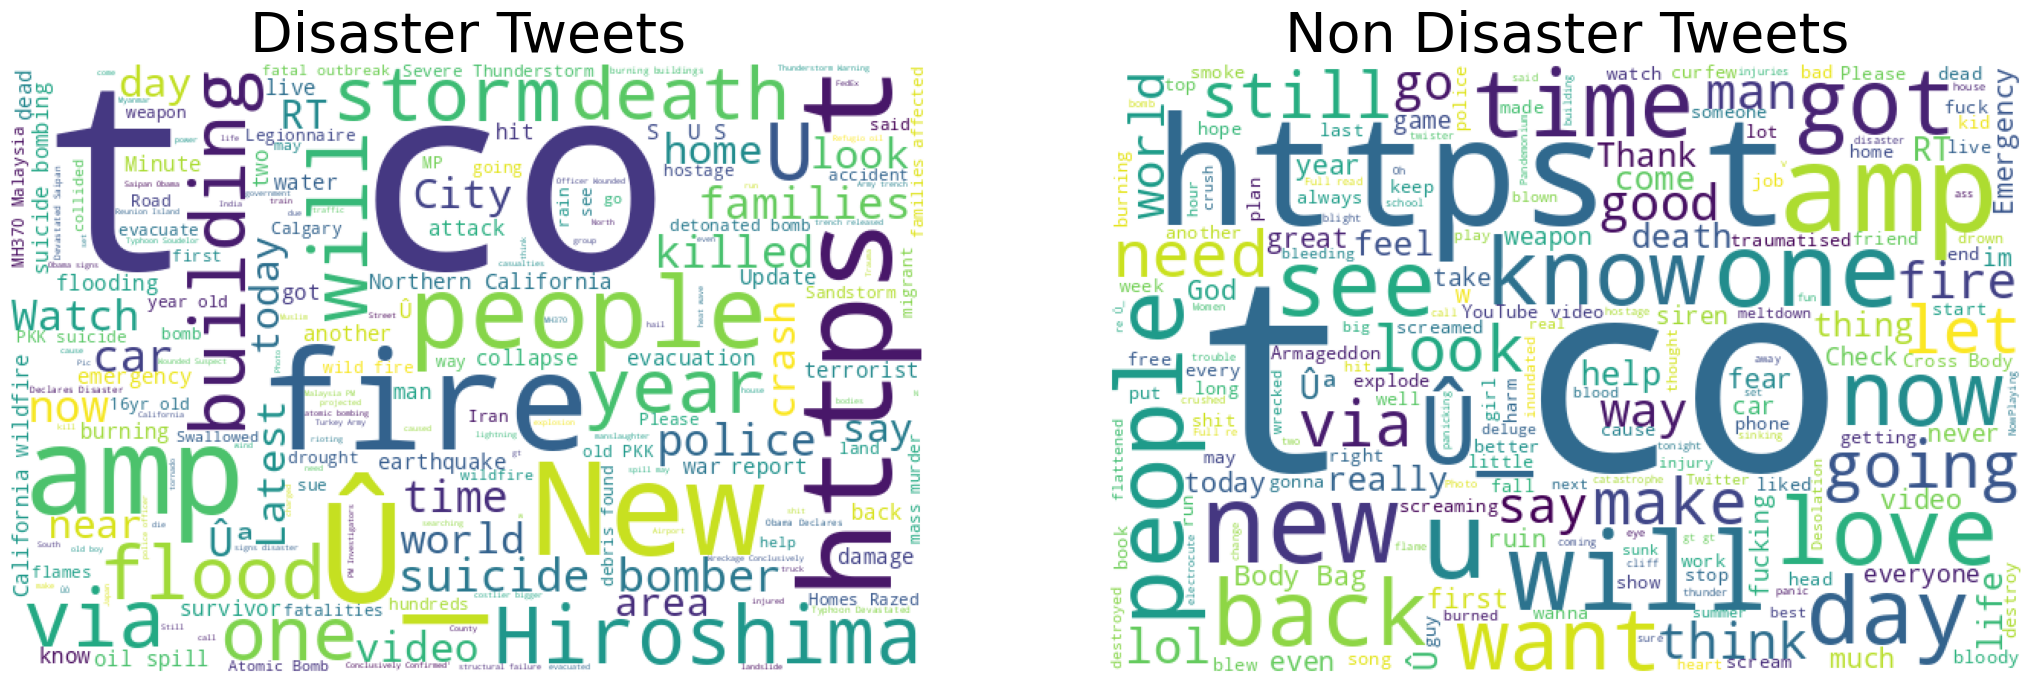

In [19]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [20]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [21]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
def remove_stopwords(text):

    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [28]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [29]:
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


In [31]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [32]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [33]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])

print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [35]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

In [36]:
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [37]:
clf.fit(train_vectors, train["target"])

LogisticRegression()

In [38]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

In [39]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [40]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB()

In [41]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [42]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB()

In [43]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.49406688, 0.37087379, 0.43429637, 0.3780359 , 0.52307692])

In [44]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.47191011, 0.36113837, 0.42638623, 0.38949672, 0.52812202])

In [45]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [46]:
submission_file_path = "sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)